# CSE 802 Project: Genre recognition using FMA
Kevin McMahon

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tracks = pd.read_csv('fma_metadata/tracks.csv')
genres = pd.read_csv('fma_metadata/genres.csv')
echonest = pd.read_csv('fma_metadata/echonest.csv')

C:\Users\Kevin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Kevin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,11,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,1

In [3]:
echonest.shape, genres.shape, tracks.shape

((13132, 250), (163, 5), (106576, 53))

# Genres
Create DataFrame consisting of #tracks and genre_id for the 8 most popular top level genres

In [4]:
genres.head()

,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


In [5]:
genres = genres.loc[genres['parent'] == 0]
genres = genres.rename(columns={genres.columns[0]: 'Genre id'})
genres.index = genres['Genre id']
base_genres = genres.drop(columns=['Genre id', 'parent', 'top_level'])
base_genres = base_genres.sort_values('#tracks', ascending = False)[:8]
print(f'{8} Most popular top-level genres')
base_genres

8 Most popular top-level genres


,#tracks,title
Genre id,,
38,38154,Experimental
15,34413,Electronic
12,32923,Rock
1235,14938,Instrumental
10,13845,Pop
17,12706,Folk
21,8389,Hip-Hop
2,5271,International


# Tracks
1. Remove first 2 rows of header info
2. Change 'track.8' genre tags from string to list
3. Index the resulting dataframe by track number

In [6]:
tracks = tracks[2:]
tracks['track.8'] = tracks['track.8'].transform(lambda x: x.strip('[]').replace(' ','').split(','))

3. Make dataframe index the track number

In [7]:
tracks = tracks.rename(columns={tracks.columns[0]: 'Track number'})
tracks.index = tracks['Track number']
tracks = tracks.drop(columns=['Track number'])
tracks.head()

,album,album.1,album.2,album.3,album.4,album.5,album.6,album.7,album.8,album.9,...,track.10,track.11,track.12,track.13,track.14,track.15,track.16,track.17,track.18,track.19
Track number,,,,,,,,,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


# Echonest
1. Eliminate first 3 rows of headers
2. Remove features from echonest that are NaN or string (artist, release date, etc)
3. Index the resulting dataframe by track number

In [8]:
echonest = echonest[3:]
echonest = echonest.drop(echonest.columns[9:21],axis=1);
echonest = echonest.rename(columns={echonest.columns[0]: 'Track number'})
echonest.index = echonest['Track number']
echonest = echonest.drop(columns=['Track number'])
echonest.head()

,echonest,echonest.1,echonest.2,echonest.3,echonest.4,echonest.5,echonest.6,echonest.7,echonest.20,echonest.21,...,echonest.239,echonest.240,echonest.241,echonest.242,echonest.243,echonest.244,echonest.245,echonest.246,echonest.247,echonest.248
Track number,,,,,,,,,,,,,,,,,,,,,
2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880,0.3889898648,0.3867400000,...,-1.9923025370,6.8056936264,0.2330697626,0.1928800046,0.0274549890,0.0640799999,3.6769599915,3.6128799915,13.3166904449,262.9297485352
3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421,0.3889898648,0.3867400000,...,-1.5823311806,8.8893079758,0.2584637702,0.2209050059,0.0813684240,0.0641300008,6.0827698708,6.0186400414,16.6735477448,325.5810852051
5,0.0435668989,0.7455658702,0.7014699916,0.0006967990,0.3731433124,0.1245953419,100.2600000000,0.6216612236,0.3889898648,0.3867400000,...,-2.2883579731,11.5271091461,0.2568213642,0.2378199995,0.0601223968,0.0601399988,5.9264898300,5.8663496971,16.0138492584,356.7557373047
10,0.9516699648,0.6581786543,0.9245251615,0.9654270154,0.1154738842,0.0329852191,111.5620000000,0.9635898919,0.5573390067,0.6142720000,...,-3.6629877090,21.5082283020,0.2833518982,0.2670699954,0.1257044971,0.0808200017,8.4140100479,8.3331899643,21.3170642853,483.4038085938
134,0.4522173071,0.5132380502,0.5604099311,0.0194426943,0.0965666940,0.5255193792,114.2900000000,0.8940722715,0.3889898648,0.3867400000,...,-1.4526963234,2.3563981056,0.2346863896,0.1995500028,0.1493317783,0.0644000024,11.2670698166,11.2026700974,26.4541797638,751.1477050781


In [9]:
echonest.shape

(13129, 237)

# Get samples from 8 base genres
- Additionally, create a dict that maps a track_id to it's top genre

In [101]:
samples_to_obtain = 10000

In [102]:
feature_space = pd.DataFrame(columns=echonest.columns)
genre_of_track = dict()

genre_map = tracks['track.8']
top_level_genres = list(base_genres.index.values)
num_samples = 1

# Get samples whose genre is one of the 8 base genres
for track_id, features in echonest.iterrows():
    try:
        track_genres = genre_map.loc[track_id]
        for gen in track_genres:
            if int(gen) in top_level_genres:
                feature_space.loc[track_id] = features
                genre_of_track[track_id] = int(gen)
                num_samples += 1
                break
    except:
        pass
    
    if num_samples > samples_to_obtain:
        break

# Dictionary, maps track_id to genre_id
genre_of_track

# DataFrame of features for each track
feature_space.shape

(100, 237)

# Feature Selection: Variance Threshold
- Remove features below a specified variance
- Observe relationship between features retained and threshold

In [103]:
from sklearn.feature_selection import VarianceThreshold

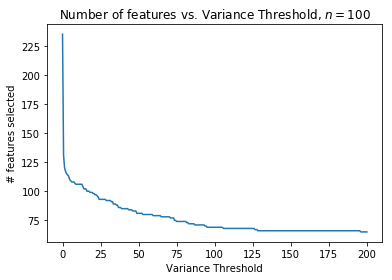

In [104]:
threshold = []
num_features = []
var_range = np.linspace(0, 200, 300)
for var in var_range:
    vt = VarianceThreshold(var)
    selected = vt.fit_transform(feature_space)
    num_features.append(len(selected[0]))
    threshold.append(var)
plt.plot(threshold, num_features)
plt.title(f'Number of features vs. Variance Threshold, $n = {len(feature_space)}$')
plt.xlabel('Variance Threshold')
plt.ylabel('# features selected');

# Feature Extraction: PCA
- Use PCA to project features to 3D scatter plot

In [81]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize

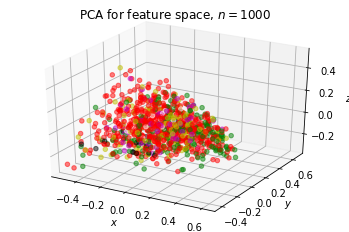

In [82]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(normalize(feature_space))

fig = plt.figure()
ax = plt.axes(projection='3d')

genre_color_map = {
    38: 'b',
    15: 'g',
    12: 'r',
    1235: 'c',
    10: 'm',
    17: 'y',
    21: 'k',
    2: 'w'
}

X=[]
Y=[]
Z=[]
colors=[]
for index, sample in enumerate(pca_data):
    # Add info to appropriate lists
    X.append(sample[0])
    Y.append(sample[1])
    Z.append(sample[2])
    
    gen = genre_of_track[feature_space.index.values[index]]
    colors.append(genre_color_map[gen])

ax.scatter(X,Y,Z, c=colors, alpha=0.5)
    
# Optionally project plot onto each axis, only useful for n < 10
# ax.scatter(X, Z, marker='>', c=colors, zdir='y')
# ax.scatter(Y, Z, marker='^', c=colors, zdir='x')
# ax.scatter(X, Y, marker='<', c=colors, zdir='z')
    
ax.set_title(f'PCA for feature space, $n = {len(feature_space)}$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$');

# Feature Extraction: LDA

In [83]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


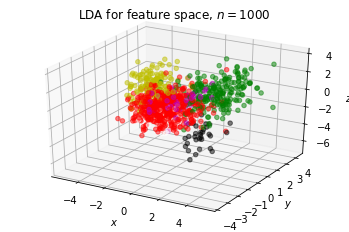

In [84]:
# Class/genre labels for each sample
track_genres = []
for track_id in list(feature_space.index.values):
    track_genres.append(genre_of_track[track_id])

lda = LDA(n_components=3)
lda_data = lda.fit_transform(feature_space, track_genres)

fig = plt.figure()
ax = plt.axes(projection='3d')

X=[]
Y=[]
Z=[]
colors=[]
for index, sample in enumerate(lda_data):
    # Add info to appropriate lists
    X.append(sample[0])
    Y.append(sample[1])
    Z.append(sample[2])
    gen = genre_of_track[feature_space.index.values[index]]
    colors.append(genre_color_map[gen])

ax.scatter(X,Y,Z, c=colors, alpha=0.5)
ax.set_title(f'LDA for feature space, $n = {len(feature_space)}$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$');

# LDA with SelectKBest
- Select the k 'best' features from the feature space
- Scale features space so features can never be negative
- Perform LDA and plot results, compare to LDA without selection

In [85]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

Specify value of $d$, number of features for each sample

In [106]:
# Max value is 237
dimensions = 200

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


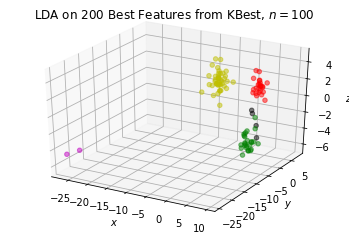

In [107]:
# Class/genre labels for each sample
track_genres = []
for track_id in list(feature_space.index.values):
    track_genres.append(genre_of_track[track_id])
    
# Scale so inputs to .fit() functions are not negative
min_max_scaler = MinMaxScaler(feature_range=(0,5))
scaled_feature_space = min_max_scaler.fit_transform(feature_space)

# K Best feature selection
kbest_features = SelectKBest(chi2, k=dimensions).fit_transform(scaled_feature_space, track_genres)

# Now use LDA to show effect of selection
# Include kbest_features to apply selection to LDA
lda = LDA(n_components=3)
lda_data = lda.fit_transform(kbest_features, track_genres)

fig = plt.figure()
ax = plt.axes(projection='3d')

X=[]
Y=[]
Z=[]
colors=[]
for index, sample in enumerate(lda_data):
    # Add info to appropriate lists
    X.append(sample[0])
    Y.append(sample[1])
    Z.append(sample[2])
    gen = genre_of_track[feature_space.index.values[index]]
    colors.append(genre_color_map[gen])

ax.scatter(X,Y,Z, c=colors, alpha=0.5)
ax.set_title(f'LDA on {dimensions} Best Features from KBest, $n = {len(feature_space)}$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

# Use for this and subsequent classifiers to group samples with their class
samples_with_labels = [(lda_data[i], track_genres[i]) for i in range(len(track_genres))]

# Bayesian Classification: MLE

In [72]:
from scipy.stats import multivariate_normal as mvn
from sklearn.model_selection import train_test_split
from sklearn.covariance import EmpiricalCovariance

In [73]:
def compute_mean(data, num_features):
    total = np.zeros(num_features, dtype=int)
    for sample in data:
        total = np.add(total, sample)
    return total/(len(data))

In [74]:
def compute_cov(data, num_features, mean):
    total = np.zeros((num_features,num_features), dtype=int)
    for sample in data:
        term1=np.subtract([sample], [mean])
        term2=np.subtract([sample], [mean]).transpose()
        mult=np.multiply(term1, term2)
        total=np.add(total, mult)
    return total/(len(data)-1)

In [105]:
sigma = []
mu = []
train_dict = dict()

train, test = train_test_split(samples_with_labels, test_size=0.25, shuffle=True)

# 
# Train
# 

for sample in train:
    if sample[1] not in train_dict:
        train_dict[sample[1]] = []
    train_dict[sample[1]].append(sample[0])
    
for genre_id, samples in train_dict.items():
    mu_i = compute_mean(samples, dimensions)
    sigma_i = compute_cov(samples, dimensions, mu_i)
    sigma.append(sigma_i)
    mu.append(mu_i)

# 
# Test
# 

test_features = [i[0] for i in test]
test_classes = [i[1] for i in test]

# Initialize confusion matrix
gen_list = []
for g in list(base_genres.title):
    gen_list.append(g[:3])

confusion = pd.DataFrame(0, index=gen_list, columns=gen_list)
confusion = confusion.rename_axis('Actual')
confusion = confusion.rename_axis('Predicted',axis='columns')

# Iterate over the testing set
for testing_index in range(len(test_classes)):
    features = test_features[testing_index]
    true_class = test_classes[testing_index]
    
    # Calculate class conditional density of each class for each sample
    class_cond = []
    for class_index, mu_i in enumerate(mu):
        sigma_i = sigma[class_index]
        rv = mvn(mean=mu_i, cov=sigma_i, allow_singular=True)
        class_cond.append(rv.pdf(features))
    
    # Add sample to confusion matrix
    j = np.argmax(class_cond)
    pred_class = list(train_dict.keys())[j]
    true_genre = base_genres.loc[true_class].title[:3]
    pred_genre = base_genres.loc[pred_class].title[:3]
    confusion.loc[true_genre].loc[pred_genre] += 1
        
# Display results
correct = sum(confusion.loc[i].loc[i] for i in gen_list)
num_samples = len(test_features)
print(f'Error rate: {(num_samples-correct)/num_samples*100}%')
confusion

ValueError: operands could not be broadcast together with shapes (50,) (3,) 

# K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
k_range = range(2,200,2)
err = []
min_confusion_matrix = []
min_error = 100.0
for k in k_range:
    kf = KFold(n_splits=10, shuffle=True)
    folds = kf.split(samples_with_labels)

    knn = KNeighborsClassifier(n_neighbors=k)
    error_rate = []
    for train, test in folds:
        train_features = [samples_with_labels[i][0] for i in train]
        train_classes = [samples_with_labels[i][1] for i in train]
        test_features = [samples_with_labels[i][0] for i in test]
        test_classes = [samples_with_labels[i][1] for i in test]

        knn.fit(train_features, train_classes)

        predicted = knn.predict(test_features)

        cm = confusion_matrix(test_classes, predicted)
        error = (1-accuracy_score(test_classes, predicted))*100
        error_rate.append(error)
        
        if error < min_error:
            min_error = error
            min_confusion_matrix = [cm, k]
        
    error = np.mean(error_rate)
    err.append(error)
    # print(f'Error rate for {splits} folds, k = {k}: {error}%')
plt.plot(k_range, err)
plt.title(f'k-NN error rate vs. k, $n = {len(track_genres)}$')
plt.xlabel('k')
plt.ylabel('Error rate, %');

print(f'Minimum classification error occured when k = {min_confusion_matrix[1]}\n')
print(f'Error rate: {np.mean(error_rate)}%\n')
print(f'Confusion Matrix:\n{min_confusion_matrix[0]}\n')
print(f'Variance: {np.var(error_rate)}')
print(f'Standard deviation: {np.std(error_rate)}')

# Multi Layer Perceptron

In [ ]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPClassifier
import scipy.stats

In [ ]:
samples_with_labels;

kf = KFold(n_splits=10, shuffle=True)
folds = kf.split(samples_with_labels)

error_rate = []

for index, splits in enumerate(folds):
    train, test = splits
    train_features = [samples_with_labels[i][0] for i in train]
    train_classes = [samples_with_labels[i][1] for i in train]
    test_features = [samples_with_labels[i][0] for i in test]
    test_classes = [samples_with_labels[i][1] for i in test]
    
    # set 15% of training data for validation
    mlp = MLPClassifier(max_iter = 500, early_stopping=True, validation_fraction=0.15)
    mlp.fit(train_features, train_classes)

    predicted = mlp.predict(test_features)

    cm = confusion_matrix(test_classes, predicted)
    error = (1-accuracy_score(test_classes, predicted))*100
    error_rate.append(error)
    
print(f'Average error rate: {np.mean(error_rate)}%')
print(f'Variance: {np.var(error_rate)}')
print(f'Standard deviation: {np.std(error_rate)}')

# Use this in other estimation techniques
samples_with_labels;

# SVM